In [1]:
#import sys
#sys.path.append('../../qclib/machine_learning/')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from qiskit import Aer, QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.opflow import Z, I, StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, PauliExpectation
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import  ZZFeatureMap, MCMT, RYGate, RealAmplitudes, TwoLocal, ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B,SPSA
from qiskit.circuit.library.standard_gates import HGate

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN, OpflowQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits

seed = 42
algorithm_globals.random_seed = 42


from auxData import Load_Data, Load_DataFull, plot_sampled_data_sepal, plot_predicted
from auxQuantum import FeatureMap, Neuron, TTN, FeatureMapFull, WeightlessNN
from feature_vector import FeatureVector
from qclib.state_preparation import BaaLowRankInitialize
from qclib.machine_learning.datasets import digits

In [2]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [3]:
# callback function that draws a live plot when the .fit() method is called
weigth_history = []
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    weigth_history.append(weights)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# DATASET

In [4]:
import numpy as np
from sklearn import datasets

from sklearn.preprocessing import StandardScaler, MinMaxScaler

X, Y = load_digits( n_class=2, return_X_y=True)
X = np.array(X[:100])
Y = np.array(Y[:100])

# Randomly shuffle data and labels 
rnd = np.random.RandomState(42)
idx = rnd.permutation(len(Y))
X, Y = X[idx], Y[idx]

# Scale to the range (0, +1)
y01 = (Y - min(Y))
y01 = y01 // max(y01)

# Scale to the range (-1, +1)
minmax_scale = MinMaxScaler((-1, 1)).fit(X)
X = minmax_scale.transform(X)
y = 2 * y01 -1

# one-hot label
num_samples = len(X)
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

num_inputs = len(X[0])
n_qubits = int(np.log2(num_inputs))

In [5]:
n_qubits

6

# WNN

In [6]:
def WeightlessNN9qubits():
    qr = QuantumRegister(9)
    qc = QuantumCircuit(qr)
    qc.append(Neuron("p1", "p2", "p3", "p4"), [0,1,6])
    qc.append(Neuron("q1", "q2", "q3", "q4"), [2,3,7])
    qc.append(Neuron("r1", "r2", "r3", "r4"), [4,5,8])
    qc.reset(1)
    qc.append(Neuron("pq1", "pq2", "pq3", "pq4"), [6,7,1])
    qc.reset(0)
    qc.append(Neuron("pqr1", "pqr2", "pqr3", "pqr4"), [1,8,0])
    return qc

def WeightlessNN11qubits():
    qr = QuantumRegister(11)
    qc = QuantumCircuit(qr)
    qc.append(Neuron("p1", "p2", "p3", "p4"), [0,1,6])
    qc.append(Neuron("q1", "q2", "q3", "q4"), [2,3,7])
    qc.append(Neuron("r1", "r2", "r3", "r4"), [4,5,8])
    qc.append(Neuron("pq1", "pq2", "pq3", "pq4"), [6,7,9])
    qc.append(Neuron("pqr1", "pqr2", "pqr3", "pqr4"), [8,9,10])
    return qc


# TRAINING

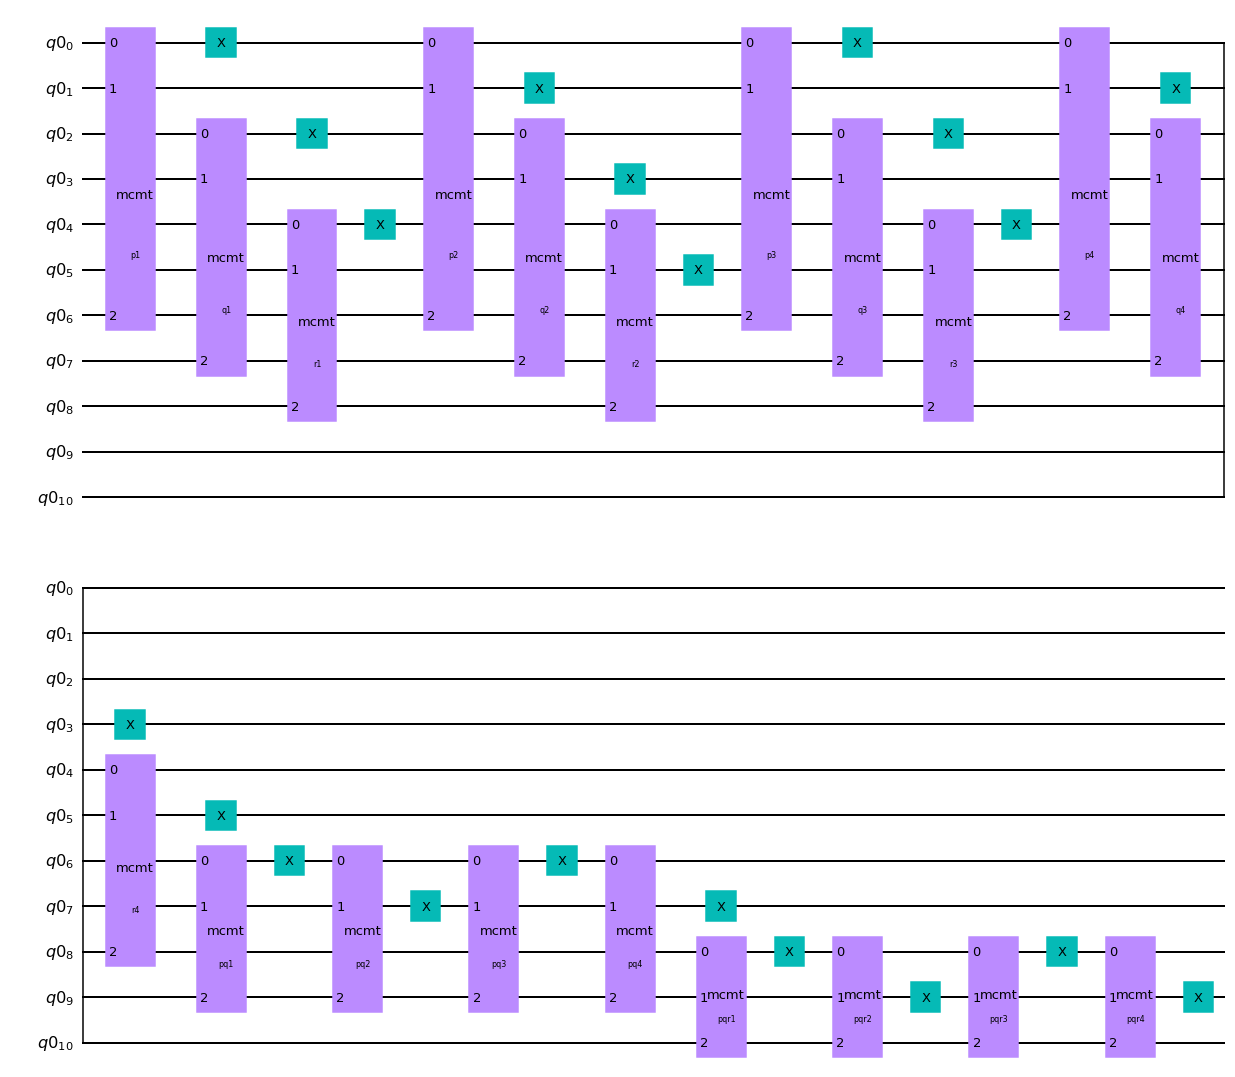

In [7]:
# construct feature map
#feature_map = ZZFeatureMap(num_inputs)
max_F_loss = 0
feature_map = FeatureVector(n_qubits, num_inputs, BaaLowRankInitialize, opt_params=None)
# construct ansatz
#ansatz = RealAmplitudes(feature_map.num_qubits, reps=2)
#ansatz = TwoLocal(feature_map.num_qubits, ['ry','rz'], 'cx', 'full', reps=2)
ansatz = WeightlessNN11qubits()

# construct variational quantum classifier
'''
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)
'''

#vqc = Neura

#feature_map.draw('mpl')
ansatz.decompose().draw('mpl')

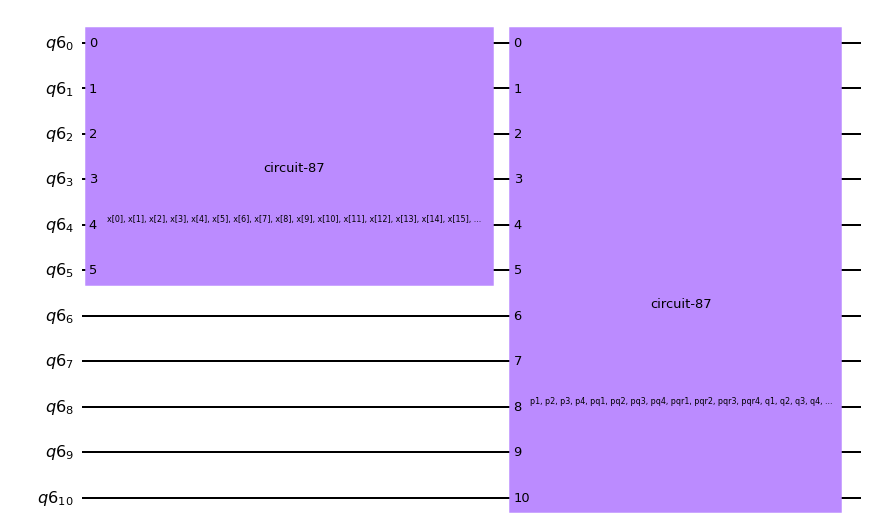

In [8]:

hamiltonian = Z ^ I ^ I ^ I ^ I ^ I ^ I ^ I ^ I ^ I ^ I
#hamiltonian = I ^ I ^ I ^ I ^ I ^ Z
qr = QuantumRegister(11)
qc = QuantumCircuit(qr)
qc.append(feature_map, [0,1,2,3,4,5])
qc.append(ansatz, [0,1,2,3,4,5,6,7,8,9,10])
qc.draw('mpl')

In [9]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)
qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)
qnn = OpflowQNN(qnn_expectation, 
                input_params=list(feature_map.parameters), 
                weight_params=list(ansatz.parameters),
                exp_val=PauliExpectation(),
                gradient=Gradient(),  
                quantum_instance=quantum_instance)

Cannot compute gradient operator! Continuing without gradients!


In [10]:
feature_map.parameters

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7]), ParameterVectorElement(x[8]), ParameterVectorElement(x[9]), ParameterVectorElement(x[10]), ParameterVectorElement(x[11]), ParameterVectorElement(x[12]), ParameterVectorElement(x[13]), ParameterVectorElement(x[14]), ParameterVectorElement(x[15]), ParameterVectorElement(x[16]), ParameterVectorElement(x[17]), ParameterVectorElement(x[18]), ParameterVectorElement(x[19]), ParameterVectorElement(x[20]), ParameterVectorElement(x[21]), ParameterVectorElement(x[22]), ParameterVectorElement(x[23]), ParameterVectorElement(x[24]), ParameterVectorElement(x[25]), ParameterVectorElement(x[26]), ParameterVectorElement(x[27]), ParameterVectorElement(x[28]), ParameterVectorElement(x[29]), ParameterVectorElement(x[30]), ParameterVectorElement(x[31]), Par

In [11]:
list(ansatz.parameters)

[Parameter(p1),
 Parameter(p2),
 Parameter(p3),
 Parameter(p4),
 Parameter(pq1),
 Parameter(pq2),
 Parameter(pq3),
 Parameter(pq4),
 Parameter(pqr1),
 Parameter(pqr2),
 Parameter(pqr3),
 Parameter(pqr4),
 Parameter(q1),
 Parameter(q2),
 Parameter(q3),
 Parameter(q4),
 Parameter(r1),
 Parameter(r2),
 Parameter(r3),
 Parameter(r4)]

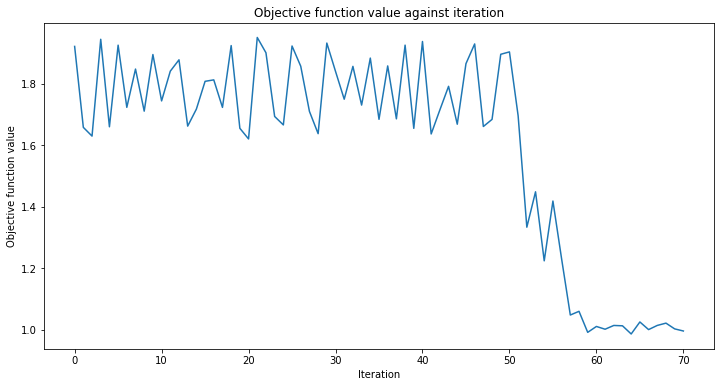

0.51

In [12]:
opflow_classifier = NeuralNetworkClassifier(qnn, optimizer=SPSA(maxiter=10), callback=callback_graph)
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
weigth_history = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
opflow_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)



# score classifier
opflow_classifier.score(X, y)

In [13]:
pred_y = opflow_classifier.predict(X)

In [22]:
pred_y.reshape(100,)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [15]:
weigth_history

[array([ 0.57395605,  0.63887844,  0.65859792,  0.49736803, -0.10582265,
         1.17562235,  0.9611397 ,  0.98606431,  0.32811363,  0.25038594,
         0.17079802,  0.72676499,  0.84386512,  1.02276161,  0.6434142 ,
         0.42723872,  0.75458479,  0.26381726,  1.02763117,  0.4316644 ]),
 array([ 0.97395605,  0.23887844,  1.05859792,  0.89736803,  0.29417735,
         0.77562235,  0.5611397 ,  0.58606431, -0.07188637,  0.65038594,
         0.57079802,  1.12676499,  0.44386512,  0.62276161,  0.2434142 ,
         0.02723872,  0.35458479, -0.13618274,  0.62763117,  0.8316644 ]),
 array([ 0.97395605,  0.23887844,  0.65859792,  0.89736803, -0.10582265,
         0.77562235,  0.9611397 ,  0.98606431, -0.07188637,  0.65038594,
         0.57079802,  1.12676499,  0.44386512,  0.62276161,  0.2434142 ,
         0.02723872,  0.75458479, -0.13618274,  1.02763117,  0.8316644 ]),
 array([0.57395605, 0.63887844, 1.05859792, 0.49736803, 0.29417735,
        1.17562235, 0.5611397 , 0.58606431, 0.3281

In [16]:
weigth_history[0]

array([ 0.57395605,  0.63887844,  0.65859792,  0.49736803, -0.10582265,
        1.17562235,  0.9611397 ,  0.98606431,  0.32811363,  0.25038594,
        0.17079802,  0.72676499,  0.84386512,  1.02276161,  0.6434142 ,
        0.42723872,  0.75458479,  0.26381726,  1.02763117,  0.4316644 ])

In [17]:
weigth_history[5]

array([ 0.97395605,  0.23887844,  1.05859792,  0.89736803,  0.29417735,
        1.17562235,  0.9611397 ,  0.58606431, -0.07188637,  0.25038594,
        0.17079802,  0.72676499,  0.84386512,  0.62276161,  0.2434142 ,
        0.02723872,  0.35458479,  0.26381726,  1.02763117,  0.8316644 ])

In [18]:
n=0
for a in range(100):
   if(pred_y[a] == y[a]):
    n+=1
   else:
    print("a", a, "pred", pred_y[a], "y", y[a])


a 7 pred [1.] y -1
a 8 pred [1.] y -1
a 9 pred [1.] y -1
a 11 pred [1.] y -1
a 13 pred [1.] y -1
a 14 pred [1.] y -1
a 15 pred [1.] y -1
a 17 pred [1.] y -1
a 18 pred [1.] y -1
a 21 pred [1.] y -1
a 22 pred [1.] y -1
a 23 pred [1.] y -1
a 24 pred [1.] y -1
a 25 pred [1.] y -1
a 30 pred [1.] y -1
a 32 pred [1.] y -1
a 34 pred [1.] y -1
a 35 pred [-1.] y 1
a 39 pred [1.] y -1
a 40 pred [1.] y -1
a 42 pred [1.] y -1
a 43 pred [1.] y -1
a 47 pred [1.] y -1
a 48 pred [1.] y -1
a 52 pred [1.] y -1
a 53 pred [1.] y -1
a 55 pred [1.] y -1
a 56 pred [1.] y -1
a 57 pred [1.] y -1
a 58 pred [1.] y -1
a 59 pred [1.] y -1
a 60 pred [1.] y -1
a 62 pred [1.] y -1
a 65 pred [1.] y -1
a 67 pred [1.] y -1
a 71 pred [1.] y -1
a 72 pred [1.] y -1
a 76 pred [1.] y -1
a 77 pred [1.] y -1
a 78 pred [1.] y -1
a 79 pred [1.] y -1
a 81 pred [1.] y -1
a 82 pred [1.] y -1
a 85 pred [1.] y -1
a 87 pred [1.] y -1
a 88 pred [1.] y -1
a 90 pred [-1.] y 1
a 93 pred [1.] y -1
a 99 pred [1.] y -1


In [19]:
n

51

In [20]:
print(X[8].reshape(64,))

[-1.         -1.         -0.66666667  0.875       0.625      -0.625
 -1.         -1.         -1.         -1.          0.25        0.875
  0.375       0.875      -1.         -1.         -1.         -0.4
  1.         -0.25       -1.          0.25       -1.         -1.
 -1.         -0.27272727  1.          0.         -1.         -0.625
  1.         -1.         -1.          1.          0.75       -0.625
 -1.         -0.5         0.77777778 -1.         -1.         -0.25
  0.875      -0.875      -1.         -0.625       0.16666667 -1.
 -1.         -1.          0.75        0.375      -0.25        0.75
 -0.16666667 -1.         -1.         -1.         -0.27272727  0.5
  0.84615385 -0.25       -1.         -1.        ]


In [21]:
"""
n_test = 10
sample_total, training_input, test_input, class_labels = digits.load(classes=[0, 1],
                                                                     training_size=40,
                                                                      test_size=10,
                                                                      random_seed=seed)

    
dataset_train0 = training_input[0]
print(dataset_train0.shape)
dataset_train1 = training_input[1]
print(dataset_train1.shape)
dataset_train_labels = np.zeros(80)
dataset_train_values = np.zeros((80,64))
for i in range(40):
    dataset_train_labels[i] = 0
    dataset_train_values[i] = dataset_train0[i]
for i in range(40):
    dataset_train_labels[i+40] = 1
    dataset_train_values[i+40] = dataset_train1[i]
num_inputs = len(training_input[class_labels[0]][0])
n_qubits = int(np.ceil(np.log2(num_inputs)))

dataset_test0 = test_input[0]
print(dataset_test0.shape)
dataset_test1 = test_input[1]
print(dataset_test1.shape)
dataset_test_labels = np.zeros(2*n_test)
dataset_test_values = np.zeros((2*n_test,64))

for i in range(n_test):
    dataset_test_labels[i] = 0
    dataset_test_values[i] = dataset_train0[i]
for i in range(n_test):
    dataset_test_labels[i+n_test] = 1
    dataset_test_values[i+n_test] = dataset_train1[i]

SyntaxError: EOF while scanning triple-quoted string literal (477170047.py, line 36)

In [ ]:
"""
"def run_experiment(max_F_loss = 0):
    hamiltonian = I^I^I^I^I^I^I^Z^I
    feature_map = FeatureVector(n_qubits, num_inputs, BaaLowRankInitialize, opt_params={'max_fidelity_loss':max_F_loss, 'strategy': 'brute_force', 'use_low_rank': True})
    ansatz = WeightlessNN9qubits()
    qr = QuantumRegister(9)
    qc = QuantumCircuit(qr)
    qc.append(feature_map, [0,1,2,3,4,5])
    qc.append(ansatz, [0,1,2,3,4,5,6,7,8])
    qc.draw('mpl')
    quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)
    qnn_expectation = StateFn(hamiltonian, is_measurement=True) @ StateFn(qc)
    qnn = OpflowQNN(qnn_expectation, 
                    input_params=list(feature_map.parameters), 
                    weight_params=list(ansatz.parameters),
                    exp_val=PauliExpectation(),
                    gradient=Gradient(),  
                    quantum_instance=quantum_instance)
    opflow_classifier = NeuralNetworkClassifier(qnn, optimizer=COBYLA(maxiter=50), callback=callback_graph)
    # create empty array for callback to store evaluations of the objective function
    objective_func_vals = []
    plt.rcParams["figure.figsize"] = (12, 6)

    # fit classifier to data
    opflow_classifier.fit(dataset_train_values, dataset_train_labels)

    # return to default figsize
    plt.rcParams["figure.figsize"] = (6, 4)

    # score classifier
    print(opflow_classifier.score(dataset_test_values, dataset_test_labels))